## Model description

This model is a piecewise linear system with different controlled continuous dynamics. The matrices $A$, $B$, $C$, $D$ describing the  modes of the hybrid system are generated randomly by using the `rss()` Matlab function. 

The  generated systems are then stabilized with an LQR controller to garantee a convergence to a stable attracting region. The transitions are determined heuristically by means of simulations. The proposed benchmark consists of 5 modes und 5 transitions. The continuous dynamics in each mode $q_i$, $i=1,\ldots,5$ is described by the following ODE:

$$
     \dot{x} = A_i x+B_i u 
$$
where  $x \in \mathbb{R}^{5}$ is the state vector and $u$ is an input signal confined in  compact bounded set $U$.

This model has 5 continuous variables, 5 modes and 5 discrete jumps.

The corresponding hybrid automaton for this benchmark is given below:

<img src="LinearSwitching.png" alt="Drawing" style="width: 300px;"/>

The model parameters and description are taken from the [HyPro collection of continuous and hybrid system benchmarks](https://ths.rwth-aachen.de/research/projects/hypro/benchmarks-of-continuous-and-hybrid-systems/), see the [5-dimensional switching linear system](https://ths.rwth-aachen.de/research/projects/hypro/5-dimensional-switching-linear-system/).

---

*References:*

-

In [1]:
using Revise # to debug
using Reachability, HybridSystems, MathematicalSystems, LazySets, LinearAlgebra, SX, SymEngine
using Plots, LaTeXStrings

┌ Warning: Package LazySets does not have Expokit in its dependencies:
│ - If you have LazySets checked out for development and have
│   added Expokit as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LazySets
│ Loading Expokit into LazySets from project dependency, future warnings for LazySets are suppressed.
└ @ nothing nothing:840
┌ Info: Recompiling stale cache file /Users/forets/.julia/compiled/v1.1/SX/qIGUA.ji for SX [2fbac1b3-cb3a-5de3-9d8f-ec145dc5cab0]
└ @ Base loading.jl:1184


In [2]:
#=
Gives:

read 2 components, but models with more than one component are not yet implemented; try flattening the model

we can possibly ignore the "system" components

file = "5_dim_linear_switch.xml"
readsxmodel(file, raw_dict=true)

=#

In [3]:
# here we have manually removed the "system" component
file = "5_dim_linear_switch_flat.xml"
model = readsxmodel(file, raw_dict=true)

┌ Warning: field labelposition in transition 1 → 2 is ignored
└ @ SX /Users/forets/.julia/dev/SX/src/parse.jl:350
┌ Warning: field labelposition in transition 2 → 3 is ignored
└ @ SX /Users/forets/.julia/dev/SX/src/parse.jl:350
┌ Warning: field labelposition in transition 3 → 4 is ignored
└ @ SX /Users/forets/.julia/dev/SX/src/parse.jl:350
┌ Warning: field labelposition in transition 4 → 5 is ignored
└ @ SX /Users/forets/.julia/dev/SX/src/parse.jl:350


Dict{String,Any} with 10 entries:
  "automaton"        => LightAutomaton{SimpleDiGraph{Int64},SimpleEdge{Int64}}(…
  "invariants"       => Array{Expr,1}[[:(x1 >= 3), :(-1 <= u <= 1)], [:(x1 >= 2…
  "transitionlabels" => Set(String[])
  "variables"        => OrderedCollections.OrderedDict(:x1=>Dict("local"=>false…
  "guards"           => Array{Expr,1}[[:(x1 = 3)], [:(x1 = 2)], [:(x1 = 1)], [:…
  "flows"            => Array{Expr,1}[[:(x1' = ((((-0.8047x1 + 8.742x2) - 2.459…
  "assignments"      => Array{Expr,1}[[], [], [], []]
  "switchings"       => AbstractSwitching[AutonomousSwitching(), AutonomousSwit…
  "nlocations"       => 5
  "ntransitions"     => 4

In [4]:
model["flows"][1]

5-element Array{Expr,1}:
 :(x1' = ((((-0.8047x1 + 8.742x2) - 2.4591x3) - 8.2714x4) - 1.864x5) - 0.0845u) 
 :(x2' = (((-8.6329x1 - 0.586x2) - 2.1006x3) + 3.6035x4) - 1.8423x5)            
 :(x3' = (((2.4511x1 + 2.2394x2) - 0.7538x3) - 3.6934x4) + 2.4585x5)            
 :(x4' = (((8.3858x1 - 3.1739x2) + 3.7822x3) - 0.6249x4) + 1.8829x5)            
 :(x5' = ((((1.8302x1 + 1.9869x2) - 2.4539x3) - 1.7726x4) - 0.7911x5) - 0.0845u)

In [5]:
function linear_switching(; X0 = Singleton([3.1, 4.0, 0.0, 0.0, 0.0]),
                            U = Interval(-1.0, 1.0),
                            T = 1.0,
                            ε = 1e-6)
        
    id_location = 1
    n = 5 # number of state variables
    m = 1 # number of input variables
    state_vars = convert.(Basic, [fi.args[1].args[1] for fi in model["flows"][id_location]])
    input_vars = [convert(Basic, collect(keys(model["variables"]))[6])] # same as convert(Basic, :u)

    A, B, c = get_coeffs(model["flows"][id_location], n, m, state_vars, input_vars) # new function in SX
    X = Universe(n)
    U = Interval(-1.0, 1.0)
    q1 = ConstrainedLinearControlContinuousSystem(A, B, X, U)

    id_location = 2
    A, B, c = get_coeffs(model["flows"][id_location], n, m, state_vars, input_vars)
    X = Universe(n)
    U = Interval(-1.0, 1.0)
    q2 = ConstrainedLinearControlContinuousSystem(A, B, X, U)
        
    id_location = 3
    A, B, c = get_coeffs(model["flows"][id_location], n, m, state_vars, input_vars)
    X = Universe(n)
    U = Interval(-1.0, 1.0)
    q3 = ConstrainedLinearControlContinuousSystem(A, B, X, U)  

    id_location = 4
    A, B, c = get_coeffs(model["flows"][id_location], n, m, state_vars, input_vars) # new function in SX
    X = Universe(n)
    U = Interval(-1.0, 1.0)
    q4 = ConstrainedLinearControlContinuousSystem(A, B, X, U)

    id_location = 5
    A, B, c = get_coeffs(model["flows"][id_location], n, m, state_vars, input_vars) # new function in SX
    X = Universe(n)
    U = Interval(-1.0, 1.0)
    q5 = ConstrainedLinearControlContinuousSystem(A, B, X, U)
        

    # automaton structure
    automaton = LightAutomaton(5)

    modes = [q1, q2, q3, q4, q5]

    # transitions
    add_transition!(automaton, 1, 2, 1)
    add_transition!(automaton, 2, 3, 2)
    add_transition!(automaton, 3, 4, 3)
    add_transition!(automaton, 4, 5, 4)
    add_transition!(automaton, 5, 1, 5)

    # guards
    G12 = HPolyhedron([HalfSpace([1.0, 0.0, 0.0, 0.0, 0.0], 3.0 + ε),
                       HalfSpace([-1.0, 0.0, 0.0, 0.0, 0.0], -3.0 + ε)]) # x1 = 3

    G23 = HPolyhedron([HalfSpace([1.0, 0.0, 0.0, 0.0, 0.0], 2.0 + ε),
                       HalfSpace([-1.0, 0.0, 0.0, 0.0, 0.0], -2.0 + ε)]) # x1 = 2

    G34 = HPolyhedron([HalfSpace([1.0, 0.0, 0.0, 0.0, 0.0], 1.0 + ε),
                       HalfSpace([-1.0, 0.0, 0.0, 0.0, 0.0], -1.0 + ε)]) # x1 = 1

    G45 = HPolyhedron([HalfSpace([1.0, 0.0, 0.0, 0.0, 0.0], 0.0 + ε),
                       HalfSpace([-1.0, 0.0, 0.0, 0.0, 0.0], -0.0 + ε)]) # x1 = 0

    G51 = HPolyhedron([HalfSpace([1.0, 0.0, 0.0, 0.0, 0.0], 1.0 + ε),
                       HalfSpace([-1.0, 0.0, 0.0, 0.0, 0.0], -1.0 + ε)]) # x1 = 1

    resetmaps = [ConstrainedIdentityMap(2, G12), 
                 ConstrainedIdentityMap(2, G23),
                 ConstrainedIdentityMap(2, G34),
                 ConstrainedIdentityMap(2, G45),
                 ConstrainedIdentityMap(2, G51)];

    # switching
    switchings = [AutonomousSwitching()]

    ℋ = HybridSystem(automaton, modes, resetmaps, switchings)

    # initial condition in mode q1
    initial_condition = [(1, X0)]

    problem = InitialValueProblem(ℋ, initial_condition)

    options = Options(:mode=>"reach", :T=>T, :plot_vars=>[1, 2], :project_reachset=>false)

    return problem, options
end

linear_switching (generic function with 1 method)

## Reachability settings

We use the initial set

$$
    x_1=3.1, x_2=4, x_3=0, x_4=0, x_5=0 \\
    u \in [-1,1]
$$

with the initial location `q1`. The time horizion is set to $T=1$.

In [12]:
X0 = Singleton([3.1, 4.0, 0.0, 0.0, 0.0])
U = Interval(-1.0, 1.0)
problem, options = linear_switching(; X0=X0, U=U, T = 1.0, ε = 1e-6);

## Results

In [13]:
using LazySets.Approximations
using LazySets.Approximations: project, overapproximate

@time begin
    opC = BFFPSV18(:δ=>0.005)
    opD = ApproximatingDiscretePost()
    sol = solve(problem, options, opC, opD)
end;

[warn | Reachability]: Several option aliases were used for aliases Symbol[:check_invariant_intersection].
[warn | Reachability]: Several option aliases were used for aliases Symbol[:overapproximation].
[warn | Reachability]: Several option aliases were used for aliases Symbol[:lazy_R⋂I].
[warn | Reachability]: Several option aliases were used for aliases Symbol[:lazy_R⋂G].
[warn | Reachability]: Several option aliases were used for aliases Symbol[:lazy_A⌜R⋂G⌟⋂I].


Computing successors 100%|██████████████████████████████| Time: 0:00:01


246.134398 seconds (1.18 G allocations: 120.798 GiB, 27.79% gc time)


In [14]:
nsamples = length(sol.Xk)

148454

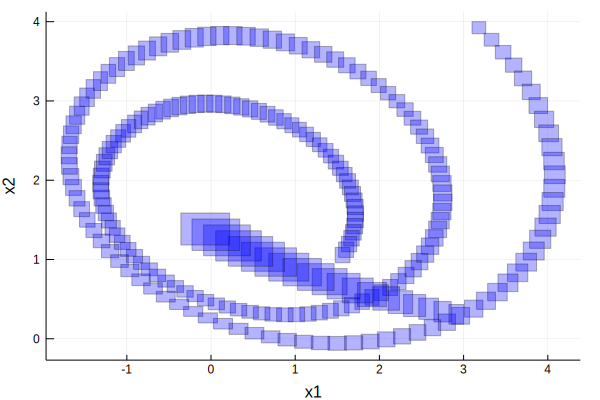

In [15]:
Xkproj = [project(sol.Xk[i].X, [1, 2], Hyperrectangle) for i in eachindex(sol.Xk)];
plot([Xkproj[i] for i in 1:1:220], xlab="x1", ylab="x2", alpha=.3)

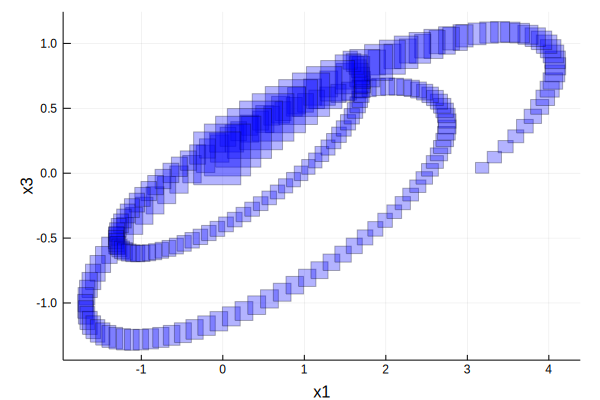

In [16]:
Xkproj = [project(sol.Xk[i].X, [1, 3], Hyperrectangle) for i in eachindex(sol.Xk)];
plot([Xkproj[i] for i in 1:1:220], xlab="x1", ylab="x3", alpha=.3)

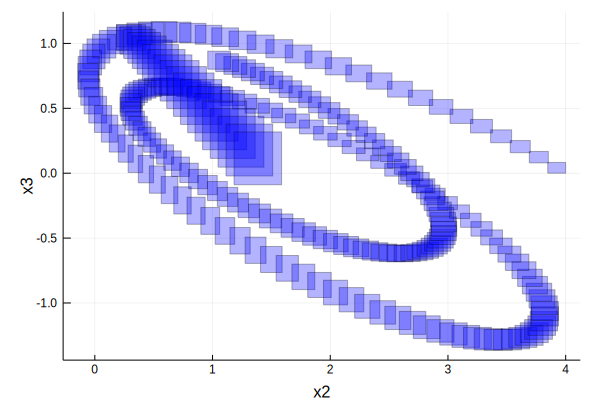

In [17]:
Xkproj = [project(sol.Xk[i].X, [2, 3], Hyperrectangle) for i in eachindex(sol.Xk)];
plot([Xkproj[i] for i in 1:1:220], xlab="x2", ylab="x3", alpha=.3)

In [ ]:
using Polyhedra

# using Concrete Discrete Post
@time begin
    opC = BFFPSV18(:δ=>0.01)
    opD = ConcreteDiscretePost()
    sol = solve(problem, options, opC, opD) # does it produce 
end;

In [ ]:
# similar to approximating discrete post ... gives big overapprox error
# with default options
using LazySets.Approximations

@time begin
    opC = BFFPSV18(:δ=>0.1)
    opD = ApproximatingDiscretePost()
    sol = solve(RodReactor, options, opC, opD)
end;

In [ ]:
# similar to approximating discrete post ... gives big overapprox error
# with default options. we try to use oct direction but it doesn't use them
using LazySets.Approximations

@time begin
    opC = BFFPSV18(:δ=>0.1)
    opD = LazyDiscretePost(:check_invariant_intersection=>true,
                           :overapproximation=>OctDirections,
                           :lazy_R⋂I=>false,
                           :lazy_R⋂G=>false,
                           :lazy_A⌜R⋂G⌟⋂I=>false)
    sol = solve(RodReactor, options, opC, opD)
end;

In [ ]:
# using Concrete Discrete Post
@time begin
    opC = BFFPSV18(:δ=>0.01)
    opD = ConcreteDiscretePost()
    sol = solve(RodReactor, options, opC, opD) # does it produce 
end;

In [ ]:
using LazySets.Approximations: project, overapproximate

In [ ]:
Xkproj = [project(sol.Xk[i].X, [1, 3], Hyperrectangle) for i in eachindex(sol.Xk)];
plot(Xkproj, xlab="x", ylab="c2")

In [ ]:
Xkproj = [project(sol.Xk[i].X, [1, 2], Hyperrectangle) for i in eachindex(sol.Xk)];
plot(Xkproj, xlab="x", ylab="c1")